In [ ]:
import pandas as pd
'''%pip install matplotlib seaborn pandas'''
import matplotlib.pyplot as plt
import seaborn as sns
'''%pip install scikit-learn'''
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

### Part 1 ‐ Exploratory data analysis

Index(['login_time'], dtype='object')


/var/folders/ls/mlx1cxs96mx4gpcd6hv_g4f00000gn/T/ipykernel_66950/2431470364.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('15T').size().reset_index(name='login_count')


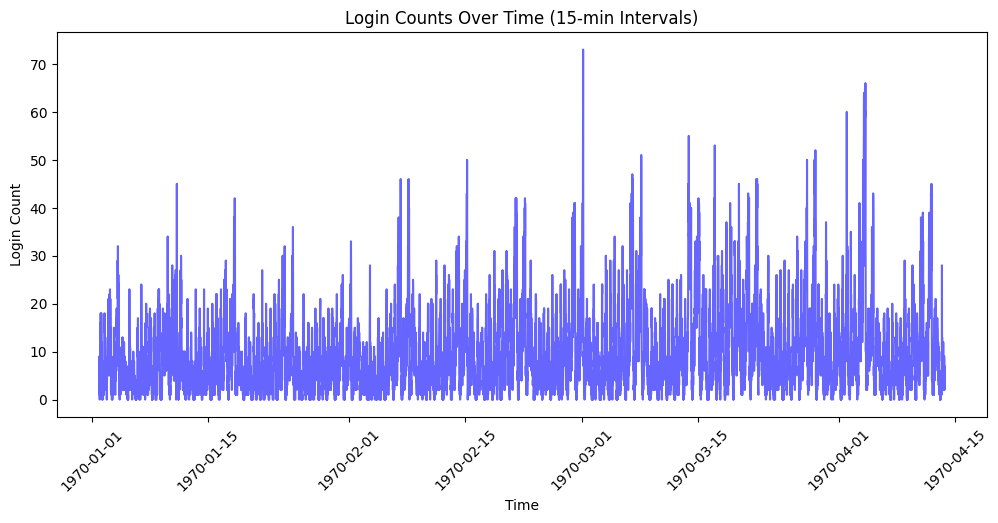

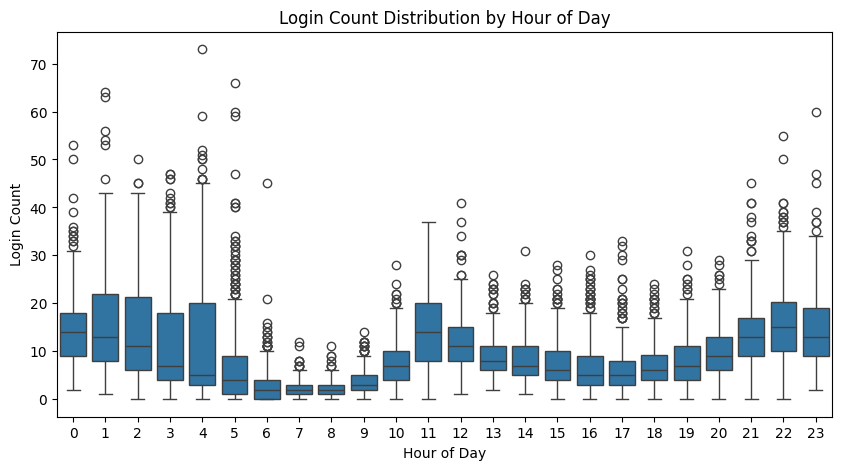

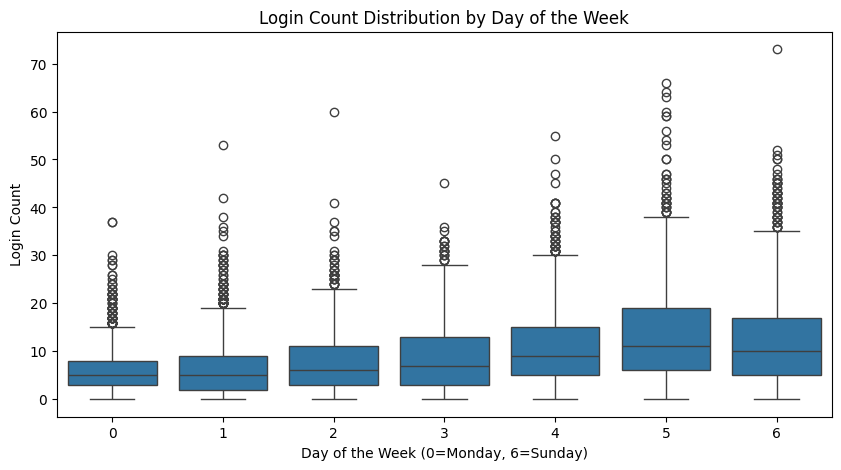

Missing values:
 login_time     0
login_count    0
hour           0
day_of_week    0
dtype: int64
Potential outliers:
               login_time  login_count  hour  day_of_week
214  1970-01-04 01:30:00           29     1            6
217  1970-01-04 02:15:00           32     2            6
218  1970-01-04 02:30:00           27     2            6
792  1970-01-10 02:00:00           29     2            5
793  1970-01-10 02:15:00           34     2            5
...                  ...          ...   ...          ...
9634 1970-04-12 04:30:00           27     4            6
9635 1970-04-12 04:45:00           45     4            6
9636 1970-04-12 05:00:00           32     5            6
9637 1970-04-12 05:15:00           28     5            6
9756 1970-04-13 11:00:00           28    11            0

[463 rows x 4 columns]


In [12]:

# Load data
df = pd.read_json("logins.json")
print(df.columns)  # Check actual column names

# Convert timestamp column to datetime
df['login_time'] = pd.to_datetime(df['login_time'])

# Set as index for resampling
df.set_index('login_time', inplace=True)

# Resample data into 15-minute intervals
df_resampled = df.resample('15T').size().reset_index(name='login_count')

# Plot login activity over time
plt.figure(figsize=(12, 5))
plt.plot(df_resampled['login_time'], df_resampled['login_count'], color='blue', alpha=0.6)
plt.title("Login Counts Over Time (15-min Intervals)")
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.xticks(rotation=45)
plt.show()

# Extract features for daily patterns
df_resampled['hour'] = df_resampled['login_time'].dt.hour
df_resampled['day_of_week'] = df_resampled['login_time'].dt.dayofweek

# Plot login count by hour of day
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_resampled['hour'], y=df_resampled['login_count'])
plt.title("Login Count Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Login Count")
plt.show()

# Plot login activity by day of the week
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_resampled['day_of_week'], y=df_resampled['login_count'])
plt.title("Login Count Distribution by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Login Count")
plt.show()

# Check for missing data
missing_values = df_resampled.isnull().sum()
print("Missing values:\n", missing_values)

# Identify outliers (logins higher than 95th percentile)
threshold = df_resampled['login_count'].quantile(0.95)
outliers = df_resampled[df_resampled['login_count'] > threshold]
print("Potential outliers:\n", outliers)


### Part 2 ‐ Experiment and metrics design

#### What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

1. The key measure of success for this experiment would be the proportion of drivers who actively operate in both the cities before and after the toll reimbursing experiment. Becasue, that would give us a better idea if the toll reimbursemnet policy have any effect on the driver behaviour.
2. We can measure this by following ways:
Number of unique drivers crossing the bridge per day/week
How many total trips each drivers are gtaking for each city
duration of trips Before and after the toll policy implementation


#### Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a) how you will implement the experiment. b)  what statistical test(s) you will conduct to verify the significance of the observation c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

a). Practical Experiment would be to do a A/B test. we can divide in two groups. 
Control Group (A): They should operate as cunder current system without their knowledgw about the experiment.
Test Group (B): They recieve full Toll reimbursments to work in both cities.

Randomly assign the drivers to control group to avoid any experimental bias
Implement the toll remimbursement policy for about 6-8 weeks and choose the test group.
Track the key metrics like, total trips, driver crossover rate , length of trips, wait times etc.
Collect the data and observe the behavioural changes between two groups.

b). Chi-Square Test (for categorical change in behavior)- Tests whether the proportion of drivers working in both cities is significantly different between control and treatment groups.

T-Test (for comparing numerical differences in trips, revenue, and wait times)- Compares the mean number of cross-city trips and revenue per driver before and after the experiment.

c). how to interpret results.
If the test group shows a statistically significant increase in cross-city driving compared to the control group, then the toll reimbursement policy is effective.
→ Recommendation: Scale up the policy and make it permanent.

If there is no significant change in driver behavior, the policy may not be a strong enough incentive.
→ Recommendation: Consider additional incentives such as increased fare bonuses or driver surge pricing for cross-city trips.





### Part 3 ‐ Predictive modeling

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [23]:

# Load data
df = pd.read_json("ultimate_data_challenge.json")
df.head(5)

# Convert date columns to datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Determine latest date in dataset
latest_date = df['last_trip_date'].max()

# Define retention: User is retained if they took a trip in the last 30 days
df['retained'] = df['last_trip_date'] >= (latest_date - pd.Timedelta(days=30))

# Compute retention rate
retention_rate = df['retained'].mean()
print(f"Retention Rate: {retention_rate:.2%}")


Retention Rate: 37.61%


Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

In [24]:
# We need to predict wheather the user will still be active in 6th month on the system. It looks like a Binary classification problem.

# Encode categorical variables
df['phone'] = df['phone'].fillna("Unknown")
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# Select features
features = ['trips_in_first_30_days', 'avg_rating_by_driver', 'avg_rating_of_driver',
            'surge_pct', 'ultimate_black_user', 'weekday_pct']
X = df[features]
y = df['retained']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.84      0.80      6219
        True       0.69      0.58      0.63      3781

    accuracy                           0.74     10000
   macro avg       0.73      0.71      0.72     10000
weighted avg       0.74      0.74      0.74     10000



For Not Retained Users:
Since precision is 0.77- It correctly predicts 77% of the time for non retained customer.
Since Recall is 0.84 - out of total non retained customers 84% of thetime models identifies correctly.
f1 score - 0.80- indicates a good balance for the Non retained category.

For Retained Category:
SInce Precision is 0.69- The model correctly predicts the retained customers 69% of the time.
Since Recall is 0.58 - out of the total retained customers Model predicts 58% of the time retained customers.
f1 score - 0.63 - indicates little low for Retained category.

Summary
The model is slightly biased towards predicting Non Retained customers.

Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Encourage more early engagement

1. Users who take more trips in the first 30 days are more likely to stay.
 Offer discounts, referral bonuses, or personalized ride recommendations.
 Improve driver and rider rating experience

2. Ratings correlate with retention.
 Improve support for poorly rated rides, reward top-rated drivers.

3. Optimize surge pricing
  Users experiencing higher surge pricing may drop off.
  Offer loyalty rewards to counteract high surge effects.
  City-based strategies

4. Retention may vary by city.
   Run city-specific engagement campaigns.